<a href="https://colab.research.google.com/github/ichencyj/AI_ML/blob/main/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile
path = "/content/drive/MyDrive/AI資料/ML/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


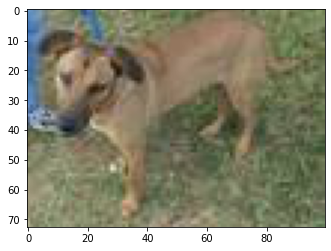

In [3]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[20]))

In [4]:
import random
import pandas as pd
dogs = glob.glob("train/dog.*")
random.shuffle(dogs)
cats = glob.glob("train/cat.*")
random.shuffle(cats)
train = pd.DataFrame({
    "path":dogs[:900] + cats[:900],
    "target":[0] * 900 + [1] * 900
})
validate = pd.DataFrame({
    "path":dogs[900:950] + cats[900:950],
    "target":[0] * 50 + [1] * 50
})
test = pd.DataFrame({
    "path":dogs[950:1000] + cats[950:1000],
    "target":[0] * 50 + [1] * 50
})

In [ ]:
test

In [7]:
#https://keras.io/zh/applications/
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
for l in vgg.layers:
    l.trainable = False
layers = [
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
layers = vgg.layers + layers
model = Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [9]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [10]:
import numpy as np

In [ ]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
fs = glob.glob("train/*")
target = fs[20]

# 預處理(要照你偷來的模型做)
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(target).resize((224, 224)).convert("RGB")
img_np = preprocess_input(np.array(img))
print(img_np)

In [ ]:
import numpy as np
x_train = np.array(train["path"])
y_train = np.array(train["target"])
x_validate = np.array(validate["path"])
y_validate = np.array(validate["target"])
x_test = np.array(test["path"])
y_test = np.array(test["target"])

In [ ]:
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input
def get_data(x, y, batch=None):
    # 如果不是None, 那代表是數字(20), 隨機20個idx
    # 如果是None, 那就沒有隨機, 拿全部
    if batch is not None:
        idx = np.random.randint(0, len(x), size=batch)
        x, y = x[idx], y[idx]
    # img_pre: preprocess過後的圖片
    # img_ori: 沒有preprocess的圖片
    img_pre, img_ori = [], []
    # 走過我的每一個path
    for p in x:
        # 讀取圖片並且預處理
        img = Image.open(p).convert("RGB").resize((224, 224))
        img = np.array(img)
        img_pre.append(preprocess_input(img))
        img_ori.append(img)
    # 回傳(預處理過後圖片, 沒處理圖片, 答案)
    return (np.array(img_pre), np.array(img_ori), y)
# 使用範例
x, x_ori, y = get_data(x_train, y_train, 10)
print(x.shape)
print(x_ori.shape)
print(y.shape)
# print(x)

(10, 224, 224, 3)
(10, 224, 224, 3)
(10,)


In [ ]:
# validate和test全部讀出來
xv, xv_ori, yv = get_data(x_validate, y_validate)
xt, xt_ori, yt = get_data(x_test, y_test)
print(xv.shape)
print(xt.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)


In [ ]:
# 我沒有使用fit: 因為使用fit你一定要把全部圖都讀好(現實世界不太可能)
# 真的自己一步一步來: train_on_batch, test_on_batch
for i in range(50):
    x, _, y = get_data(x_train, y_train, batch=20)
    result = model.train_on_batch(x, y)
    print("train:", result)
    result = model.test_on_batch(xv, yv)
    print("validate:", result)
    print("-" * 15, i, "end", "-" * 15)

train: [6.48565149307251, 0.30000001192092896]
validate: [5.2636613845825195, 0.4699999988079071]
--------------- 0 end ---------------
train: [4.430539131164551, 0.44999998807907104]
validate: [4.545530319213867, 0.44999998807907104]
--------------- 1 end ---------------
train: [5.701215744018555, 0.44999998807907104]
validate: [3.8117058277130127, 0.4399999976158142]
--------------- 2 end ---------------
train: [3.85760498046875, 0.3499999940395355]
